In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Parameters
batch_size = 64
image_size = 28 * 28  # MNIST images are 28x28
latent_dim = 100      # Dimensionality of the noise input to generator
epochs = 30
learning_rate = 0.0002

In [11]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize between -1 and 1
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True),
    batch_size=batch_size, shuffle=True
)

In [12]:
# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# Initialize networks and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [14]:

# Training
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.view(-1, image_size).to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # # /
        gen_images = generator(noise)
        outputs = discriminator(gen_images)
        # # /
        # outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")




Epoch [1/30], D Loss: 0.0009, G Loss: 13.7337
Epoch [2/30], D Loss: 0.0001, G Loss: 17.5043
Epoch [3/30], D Loss: 0.0000, G Loss: 17.3355
Epoch [4/30], D Loss: 0.0000, G Loss: 23.3196
Epoch [5/30], D Loss: 0.0000, G Loss: 25.4329
Epoch [6/30], D Loss: 0.0000, G Loss: 27.6730
Epoch [7/30], D Loss: 0.0000, G Loss: 29.3485
Epoch [8/30], D Loss: 0.0000, G Loss: 31.9470
Epoch [9/30], D Loss: 0.0000, G Loss: 30.2269
Epoch [10/30], D Loss: 0.0000, G Loss: 38.5245
Epoch [11/30], D Loss: 0.0000, G Loss: 36.0463
Epoch [12/30], D Loss: 0.0000, G Loss: 37.8004
Epoch [13/30], D Loss: 0.0000, G Loss: 37.8290
Epoch [14/30], D Loss: 0.0000, G Loss: 37.3144
Epoch [15/30], D Loss: 0.0000, G Loss: 35.3245
Epoch [16/30], D Loss: 0.0000, G Loss: 38.2161
Epoch [17/30], D Loss: 0.0000, G Loss: 59.9284
Epoch [18/30], D Loss: 0.0000, G Loss: 59.5209
Epoch [19/30], D Loss: 0.0000, G Loss: 55.9863
Epoch [20/30], D Loss: 0.0000, G Loss: 55.2268
Epoch [21/30], D Loss: 0.0000, G Loss: 51.1350
Epoch [22/30], D Loss:

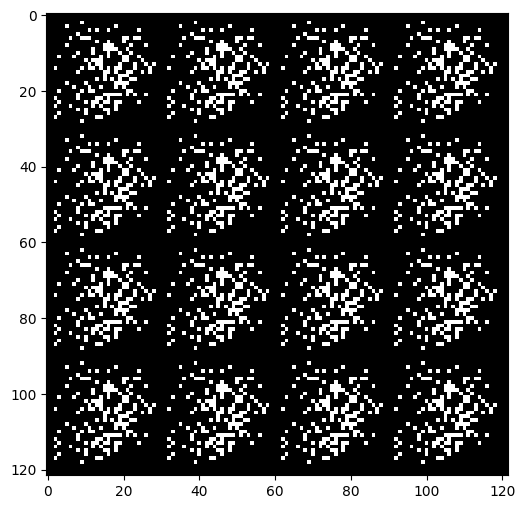

In [15]:
# Generate some images
noise = torch.randn(16, latent_dim).to(device)
generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()
grid = make_grid(generated_images, nrow=4, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()